# Author : Karthikeyan S

# Problem Statement

We are trying to predict the stock price of a particular company by taking the company's historical stock price data and try to see if the historical data has any impact. We also tried to anlyze the news headlines of the previous day, gets its sentiment and try to combine the information that we got with the historical data and build a hyrbid model that predicts Stock Price.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
%matplotlib inline
sns.set()
import math
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)
pd.set_option('display.max_colwidth',300)

# Getting 2 years of stock price data

In [3]:
data = yf.download('^BSESN',start='2021-01-01', end = '2023-09-10')

[*********************100%%**********************]  1 of 1 completed


In [4]:
df_stock = data.copy()

In [5]:
df_stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,47785.281250,47984.359375,47771.148438,47868.980469,47868.980469,82700
2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,48176.800781,13900
2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,48437.781250,12200
2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,48174.058594,22500
2021-01-07,48524.359375,48558.339844,48037.871094,48093.320312,48093.320312,18400


In [6]:
df_stock.shape

(666, 6)

In [7]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 666 entries, 2021-01-01 to 2023-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       666 non-null    float64
 1   High       666 non-null    float64
 2   Low        666 non-null    float64
 3   Close      666 non-null    float64
 4   Adj Close  666 non-null    float64
 5   Volume     666 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 36.4 KB


In [8]:
df_stock.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df_stock.index

DatetimeIndex(['2021-01-01', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14',
               ...
               '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31',
               '2023-09-01', '2023-09-04', '2023-09-05', '2023-09-06',
               '2023-09-07', '2023-09-08'],
              dtype='datetime64[ns]', name='Date', length=666, freq=None)

Let's look at our time series

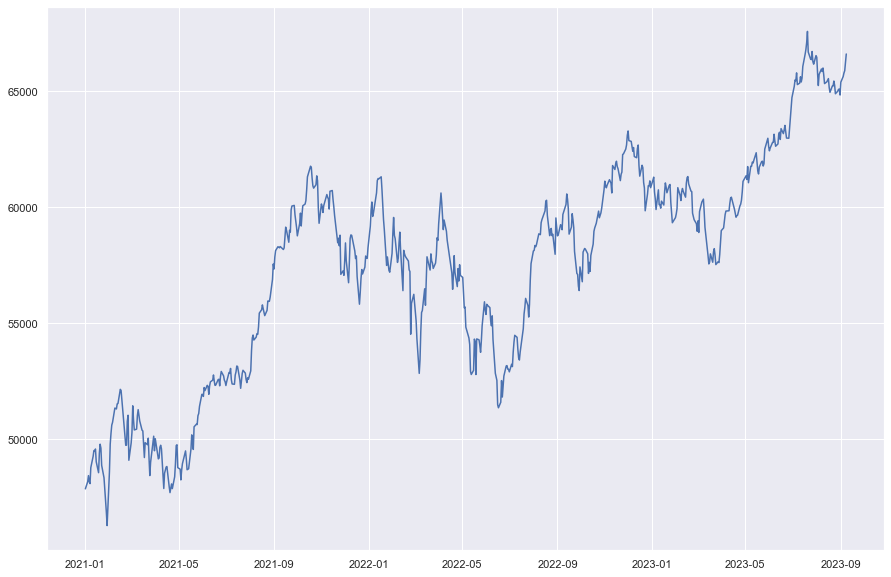

In [10]:
plt.figure(figsize=(15,10))
plt.plot(df_stock['Close'])

In [11]:
decomposition = seasonal_decompose(df_stock['Close'],period=1)

<Figure size 432x288 with 0 Axes>

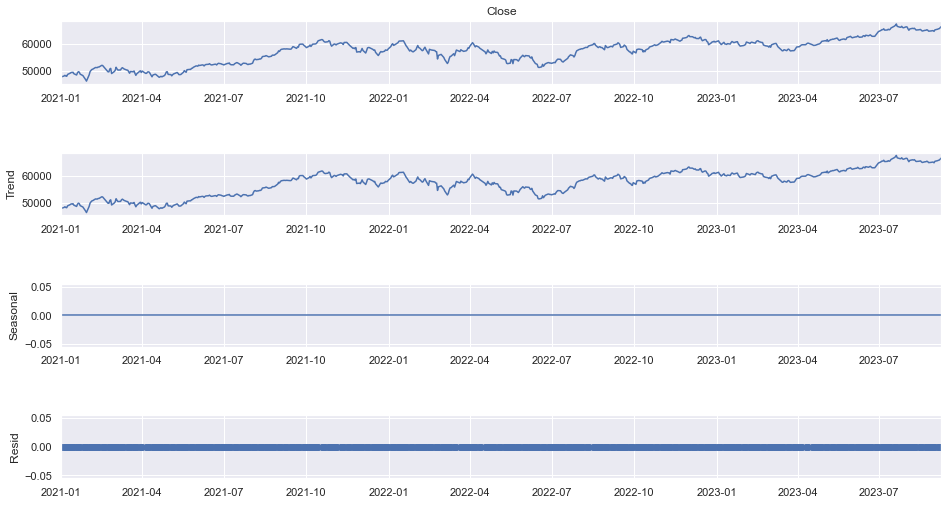

In [12]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [13]:
df_stock.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,47785.281250,47984.359375,47771.148438,47868.980469,47868.980469,82700
2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,48176.800781,13900
2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,48437.781250,12200
2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,48174.058594,22500
2021-01-07,48524.359375,48558.339844,48037.871094,48093.320312,48093.320312,18400
2021-01-08,48464.910156,48854.339844,48365.578125,48782.511719,48782.511719,22200
2021-01-11,49252.308594,49303.789062,48956.378906,49269.320312,49269.320312,21200
2021-01-12,49228.261719,49569.140625,49079.570312,49517.109375,49517.109375,12700
2021-01-13,49763.929688,49795.191406,49073.851562,49492.320312,49492.320312,27200


In [14]:
#Taking the necessary columns and sorting them by index (date)
his_df=df_stock[["Open","High","Low","Close","Volume"]]
his_df = his_df.sort_index(ascending = True, axis = 0)

In [15]:
his_df

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01,47785.281250,47984.359375,47771.148438,47868.980469,82700
2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,13900
2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,12200
2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,22500
2021-01-07,48524.359375,48558.339844,48037.871094,48093.320312,18400
...,...,...,...,...,...
2023-09-04,65525.910156,65683.906250,65285.558594,65628.140625,13700
2023-09-05,65671.601562,65831.703125,65601.468750,65780.257812,6600
2023-09-06,65744.187500,65971.132812,65488.031250,65880.523438,6100


In [16]:
his_df.describe()

,Open,High,Low,Close,Volume
count,666.000000,666.000000,666.000000,666.000000,666.000000
mean,57490.878701,57771.046728,57135.584976,57465.544066,11011.711712
std,4701.187136,4686.395753,4746.434834,4719.817461,8593.568906
min,46617.949219,47172.019531,46160.460938,46285.769531,0.000000
25%,53504.400391,53829.801758,53126.412109,53446.604492,6700.000000
50%,58291.974609,58561.144531,57934.554688,58266.650391,8500.000000
75%,60713.620117,60875.336914,60372.166992,60670.486328,12475.000000
max,67074.343750,67619.171875,66831.382812,67571.898438,82700.000000


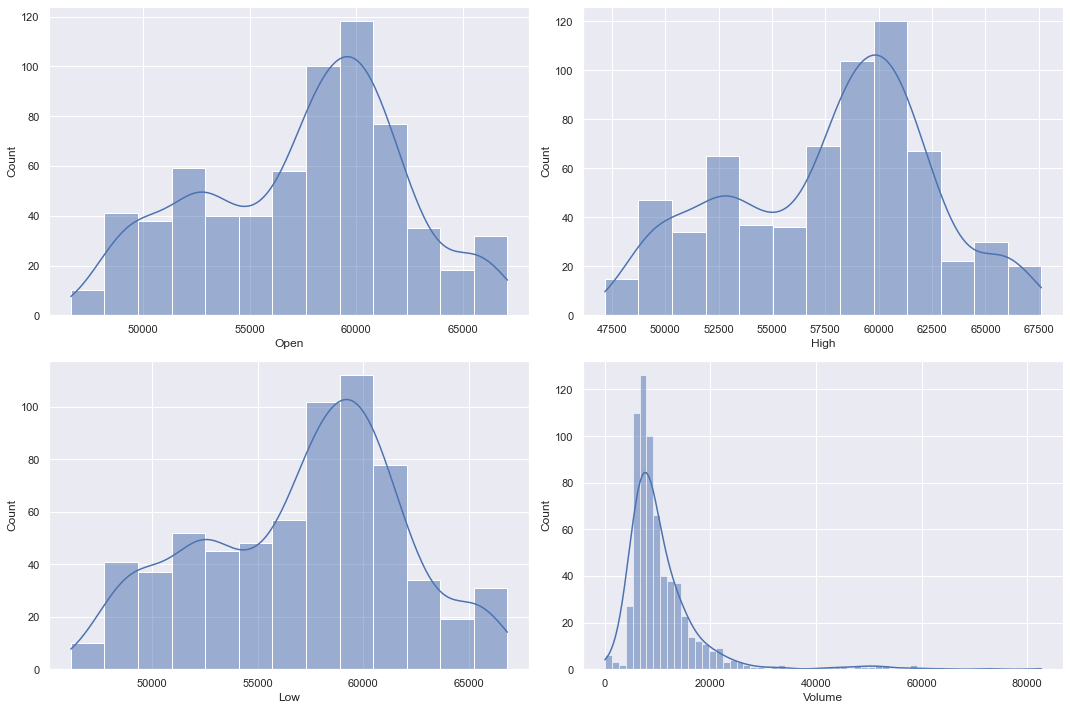

In [17]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
c=0
for i in range(2):
    for j in range(2):
        sns.histplot(data = his_df, x = his_df.drop('Close',axis=1).columns[i+j+c],kde=True,ax=axes[i,j])
    c+=j
plt.tight_layout(pad =1)


<AxesSubplot:xlabel='Close', ylabel='Count'>

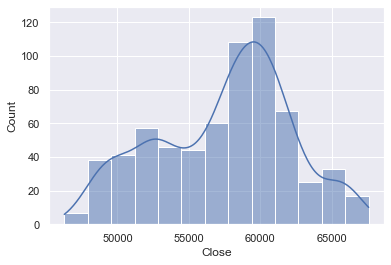

In [18]:
sns.histplot(data = his_df, x = 'Close',kde=True)

In [19]:
model_df = his_df.shift(1)

In [20]:
model_df.dropna(inplace=True)

In [21]:
his_df['Close'][1:]

Date
2021-01-04    48176.800781
2021-01-05    48437.781250
2021-01-06    48174.058594
2021-01-07    48093.320312
2021-01-08    48782.511719
                  ...     
2023-09-04    65628.140625
2023-09-05    65780.257812
2023-09-06    65880.523438
2023-09-07    66265.562500
2023-09-08    66598.906250
Name: Close, Length: 665, dtype: float64

In [22]:
model_df['Target_variable'] = his_df['Close'][1:]

In [23]:
model_df

,Open,High,Low,Close,Volume,Target_variable
Date,,,,,,
2021-01-04,47785.281250,47984.359375,47771.148438,47868.980469,82700.0,48176.800781
2021-01-05,48109.171875,48220.468750,47594.468750,48176.800781,13900.0,48437.781250
2021-01-06,48037.628906,48486.238281,47903.378906,48437.781250,12200.0,48174.058594
2021-01-07,48616.660156,48616.660156,47864.140625,48174.058594,22500.0,48093.320312
2021-01-08,48524.359375,48558.339844,48037.871094,48093.320312,18400.0,48782.511719
...,...,...,...,...,...,...
2023-09-04,64855.511719,65473.269531,64818.371094,65387.160156,21600.0,65628.140625
2023-09-05,65525.910156,65683.906250,65285.558594,65628.140625,13700.0,65780.257812
2023-09-06,65671.601562,65831.703125,65601.468750,65780.257812,6600.0,65880.523438


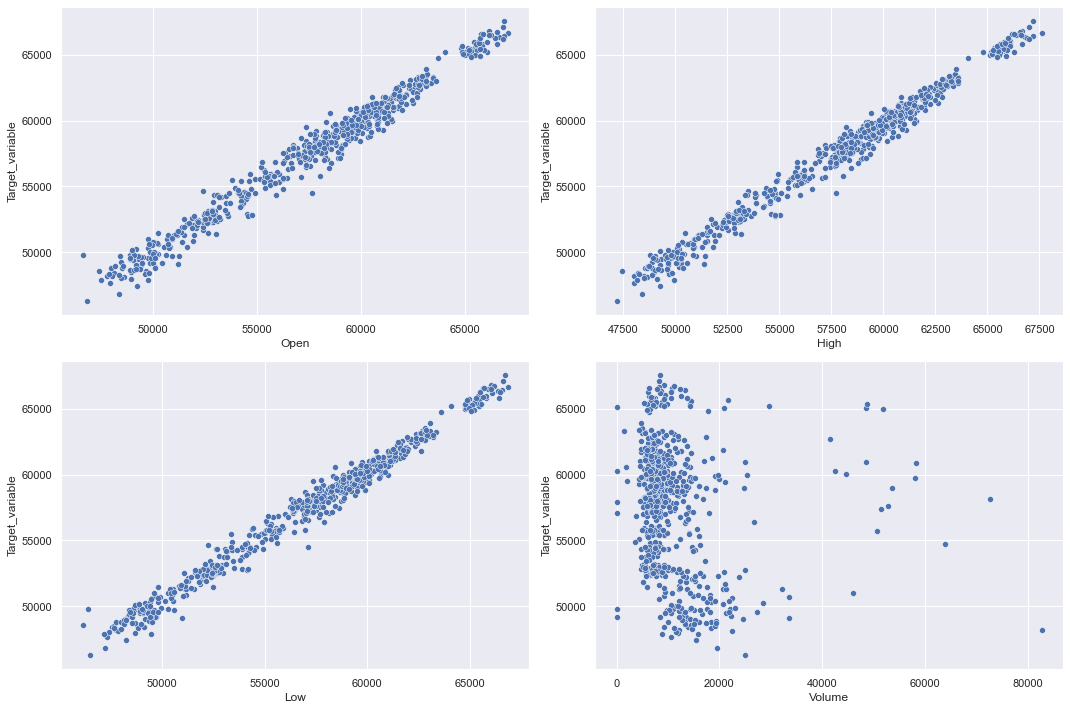

In [24]:
#Let's try to look at each variable's relationship with the target variable (Close)
fig, axes = plt.subplots(2,2, figsize=(15,10))
c=0
for i in range(2):
    for j in range(2):
        sns.scatterplot(data = model_df, x = model_df.drop(['Close','Target_variable'],axis=1).columns[i+j+c],y = 'Target_variable',ax=axes[i,j])
    c+=j
plt.tight_layout(pad =1)


<AxesSubplot:xlabel='Close', ylabel='Target_variable'>

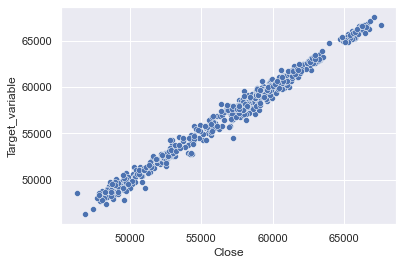

In [25]:
sns.scatterplot(data = model_df, x = 'Close',y = 'Target_variable')

In [26]:
train_len = int(0.75*len(model_df))

In [27]:
train_df= model_df[:train_len]
test_df = model_df[train_len:]

In [28]:
x_train = train_df.drop('Target_variable',axis=1)
y_train = train_df['Target_variable']
x_test = test_df.drop('Target_variable',axis=1)
y_test = test_df['Target_variable']

In [29]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    l=['Training R2 Score','Testing R2 Score','Training RMSE','Test RMSE']
    res = [m.score(x_train, y_train),m.score(x_test, y_test), 
           rmse(m.predict(x_train), y_train), rmse(m.predict(x_test), y_test)]
    
    for i,j in dict(zip(l,res)).items():
        print(f'\n{i}: ')
        print(j)

In [30]:
rf = RandomForestRegressor()

In [31]:
rf.fit(x_train, y_train)

RandomForestRegressor()

In [32]:
print_score(rf)


Training R2 Score: 
0.9968344634779356

Testing R2 Score: 
0.6276477934000556

Training RMSE: 
232.3280187313011

Test RMSE: 
1642.2278156283423


In [33]:
rf_1 = RandomForestRegressor(min_samples_leaf=3)

In [34]:
rf_1.fit(x_train,y_train)

RandomForestRegressor(min_samples_leaf=3)

In [35]:
print_score(rf_1)


Training R2 Score: 
0.9924432856538971

Testing R2 Score: 
0.606732584317385

Training RMSE: 
358.95865344868236

Test RMSE: 
1687.7200896971037


In [36]:
lr = LinearRegression()

In [37]:
lr.fit(x_train,y_train)

LinearRegression()

In [38]:
print_score(lr)


Training R2 Score: 
0.9808483014112224

Testing R2 Score: 
0.9795624804878789

Training RMSE: 
571.4543903381847

Test RMSE: 
384.7428256286068


In [39]:
x_train

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,47785.281250,47984.359375,47771.148438,47868.980469,82700.0
2021-01-05,48109.171875,48220.468750,47594.468750,48176.800781,13900.0
2021-01-06,48037.628906,48486.238281,47903.378906,48437.781250,12200.0
2021-01-07,48616.660156,48616.660156,47864.140625,48174.058594,22500.0
2021-01-08,48524.359375,48558.339844,48037.871094,48093.320312,18400.0
...,...,...,...,...,...
2022-12-30,60628.289062,61210.648438,60479.058594,61133.878906,7900.0
2023-01-02,61329.160156,61392.679688,60743.710938,60840.738281,8000.0
2023-01-03,60871.238281,61222.789062,60764.628906,61167.789062,18500.0


In [40]:
lr.fit(x_train.drop(['Open','High','Low','Volume'],axis=1),y_train)

LinearRegression()

In [41]:
print(lr.score(x_test.drop(['Open','High','Low','Volume'],axis=1),y_test))

0.9795137345630109


In [42]:
print(lr.score(x_train.drop(['Open','High','Low','Volume'],axis=1),y_train))

0.9807426544296229


In [43]:
#So, we could make good predictions from the previous day available stock price.

In [44]:
lag_1_train = pd.DataFrame(x_train['Close'])
lag_1_test = pd.DataFrame(x_test['Close'])


In [45]:
x_test['Close'].values

array([60353.26953125, 59900.37109375, 60747.30859375, 60115.48046875,
       60105.5       , 59958.03125   , 60261.1796875 , 60092.96875   ,
       60655.71875   , 61045.73828125, 60858.4296875 , 60621.76953125,
       60941.671875  , 60978.75      , 60205.05859375, 59330.8984375 ,
       59500.41015625, 59549.8984375 , 59708.078125  , 59932.23828125,
       60841.87890625, 60506.8984375 , 60286.0390625 , 60663.7890625 ,
       60806.21875   , 60682.69921875, 60431.83984375, 61032.26171875,
       61275.08984375, 61319.51171875, 61002.5703125 , 60691.5390625 ,
       60672.71875   , 59744.98046875, 59605.80078125, 59463.9296875 ,
       59288.3515625 , 58962.12109375, 59411.078125  , 58909.3515625 ,
       59808.96875   , 60224.4609375 , 60348.08984375, 59806.28125   ,
       59135.12890625, 58237.8515625 , 57900.19140625, 57555.8984375 ,
       57634.83984375, 57989.8984375 , 57628.94921875, 58074.6796875 ,
       58214.58984375, 57925.28125   , 57527.1015625 , 57653.859375  ,
      

In [46]:
predictions_test = lr.predict(lag_1_test)

In [47]:
prediction_df = pd.DataFrame({'Test':y_test,'Predictions':predictions_test})

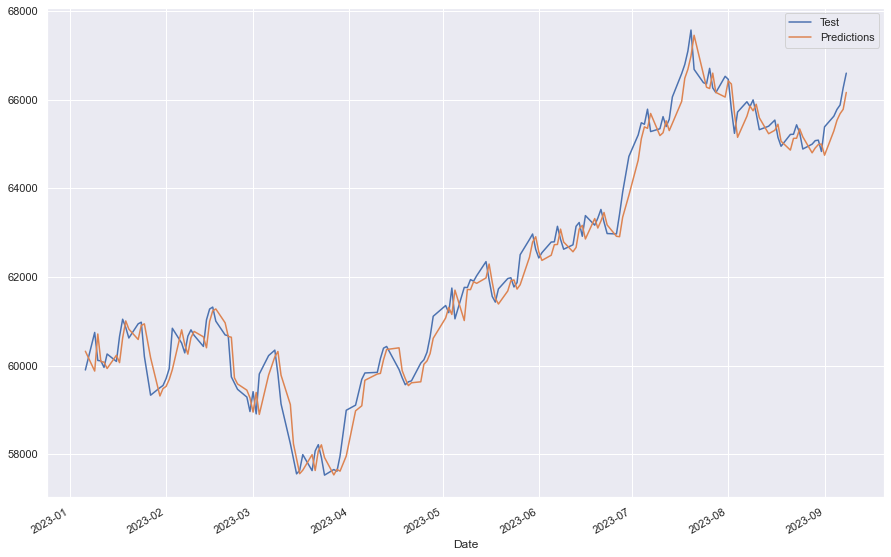

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
prediction_df.plot(ax= ax)
plt.show()

In [49]:
predictions_total = lr.predict(model_df[['Close']])

In [50]:
model_df['Prediction'] = predictions_total

# Whole data prediction  

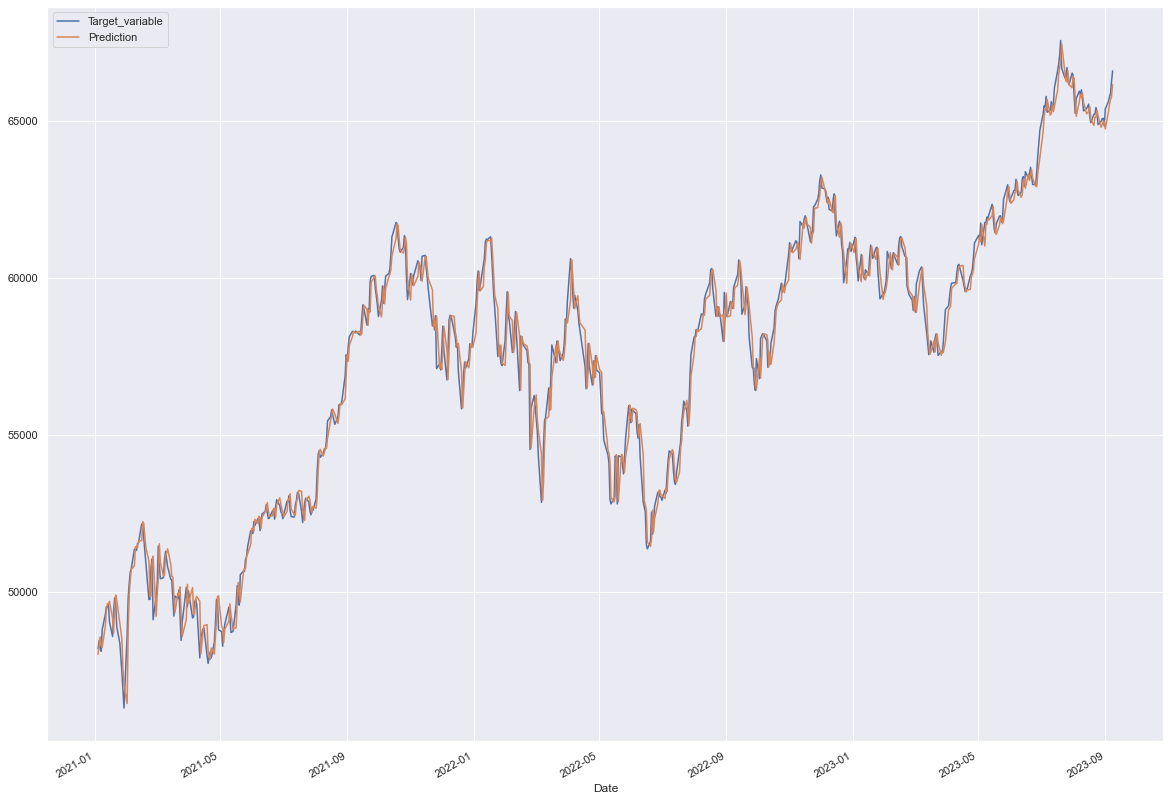

In [51]:
fig, ax = plt.subplots(figsize=(20,15))
model_df[['Target_variable','Prediction']].plot(ax=ax)
plt.show()


# Lets try actual time series models

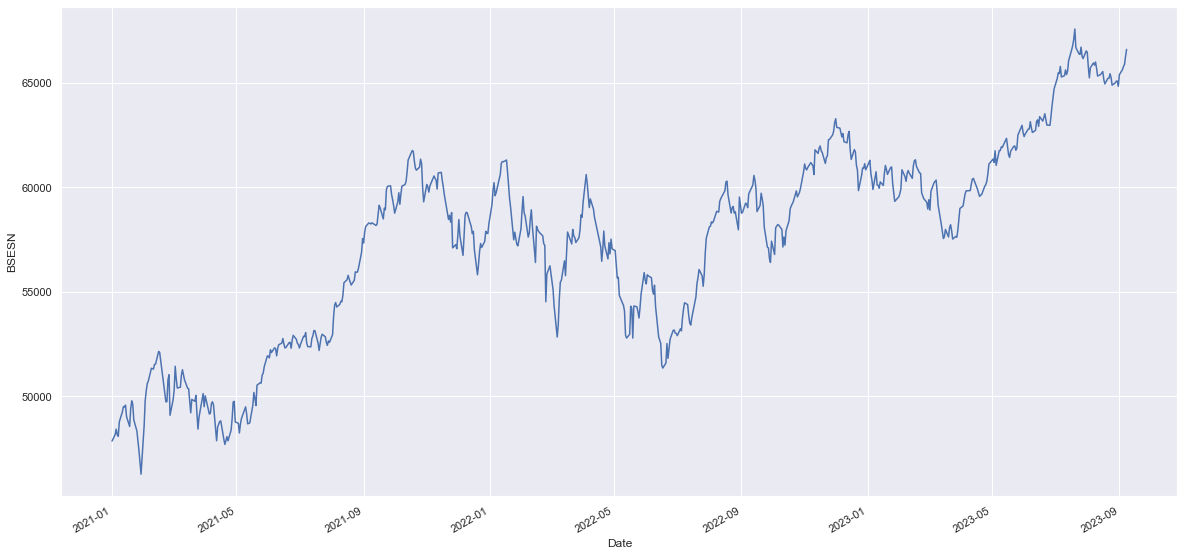

In [52]:
plt.figure(figsize=(20,10))
df_stock['Close'].plot()
plt.ylabel('BSESN')
plt.show()

# Plot the Moving Average

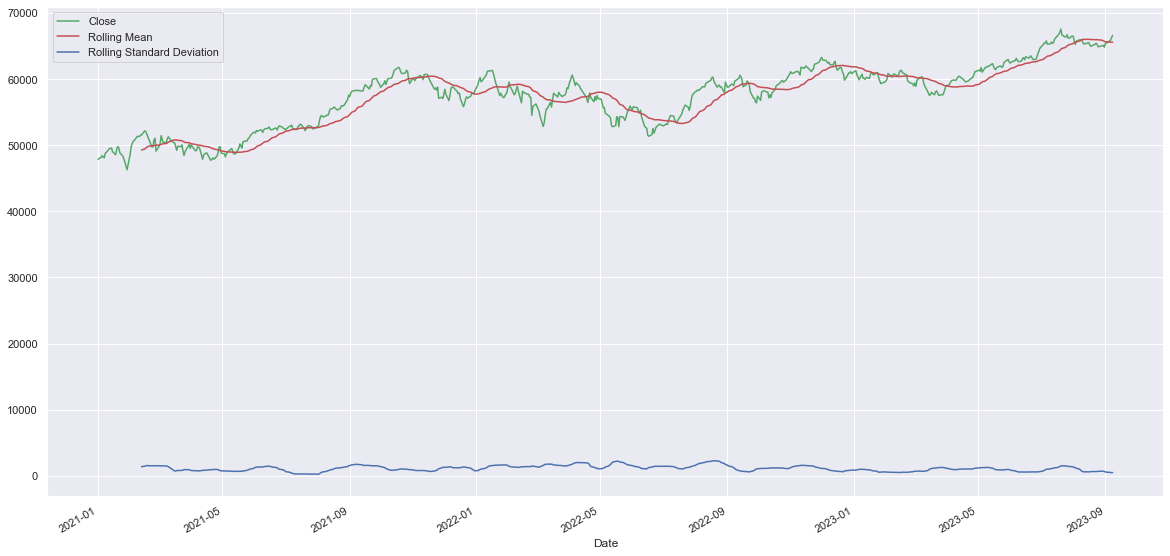

In [53]:
close = df_stock['Close']

ma = close.rolling(window = 30).mean()
std = close.rolling(window = 30).std()

plt.figure(figsize=(20,10))
df_stock['Close'].plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

In [54]:
# From the above plot, it seems the mean is not constant. lets check it with a stationary test

In [55]:
train_len

498

In [56]:
train = df_stock[:600]
test = df_stock[600:]

In [57]:
def stationary_test(timeseries):
    print('Results of dickey fuller test')
    result = adfuller(timeseries)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary ")

In [58]:
stationary_test(train['Close'])

Results of dickey fuller test
ADF Test Statistic : -1.9628052336295745
p-value : 0.30311595195082075
#Lags Used : 0
Number of Observations Used : 599
Weak evidence against null hypothesis, time series is non-stationary 


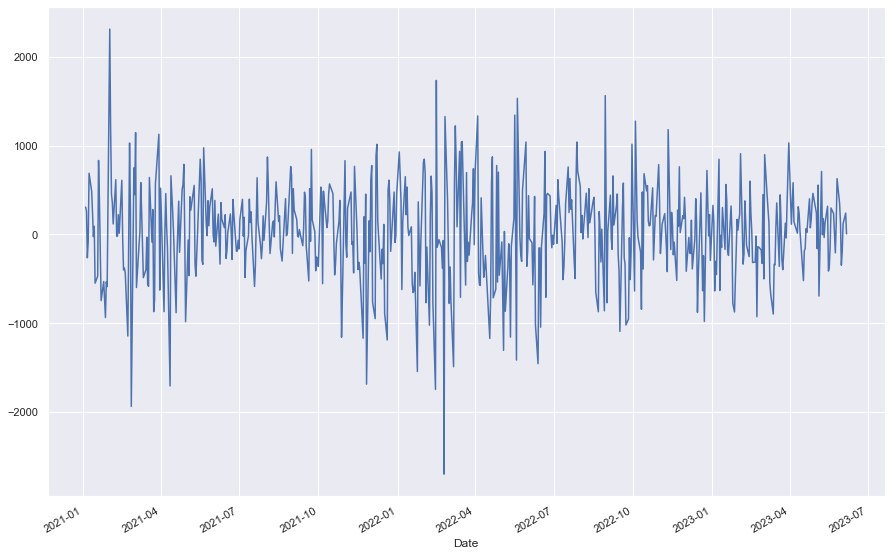

In [59]:
trend_removed_train = train['Close'] - train['Close'].shift(1) #### first order normal differencing
trend_removed_test = test['Close'] - test['Close'].shift(1) #### first order normal differencing

trend_removed_train = trend_removed_train.dropna()
trend_removed_test = trend_removed_test.dropna()

plt.figure(figsize=(15,10))
trend_removed_train.plot()
plt.show()

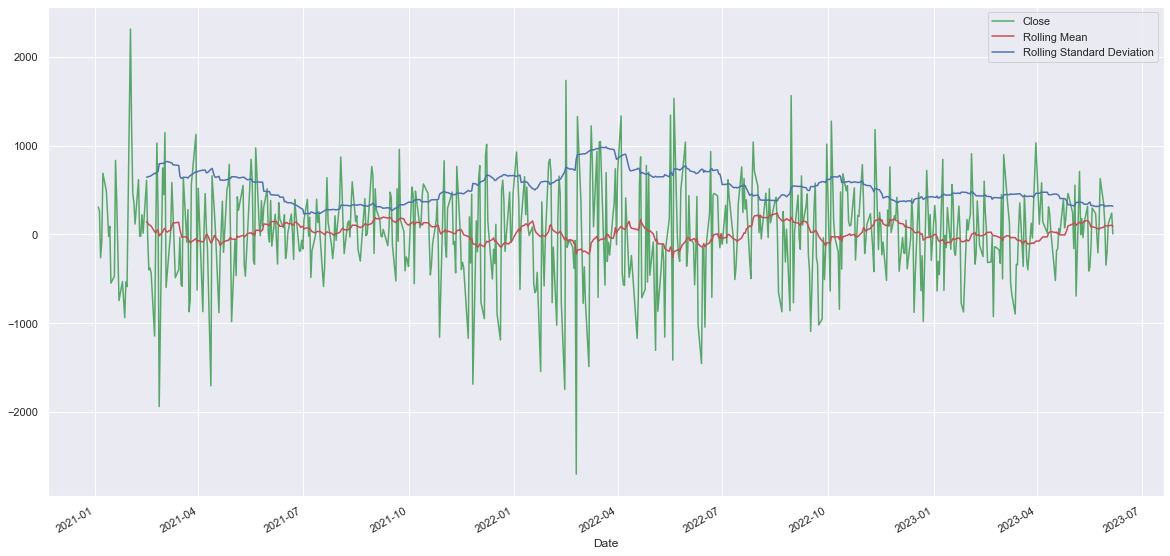

In [60]:
close = trend_removed_train

ma = close.rolling(window = 30).mean()
std = close.rolling(window = 30).std()

plt.figure(figsize=(20,10))
trend_removed_train.plot(color='g',label='Close')
ma.plot(color = 'r',label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')

plt.legend()

In [61]:
stationary_test(trend_removed_train)

Results of dickey fuller test
ADF Test Statistic : -17.925823120786507
p-value : 2.8950738387220657e-30
#Lags Used : 1
Number of Observations Used : 597
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


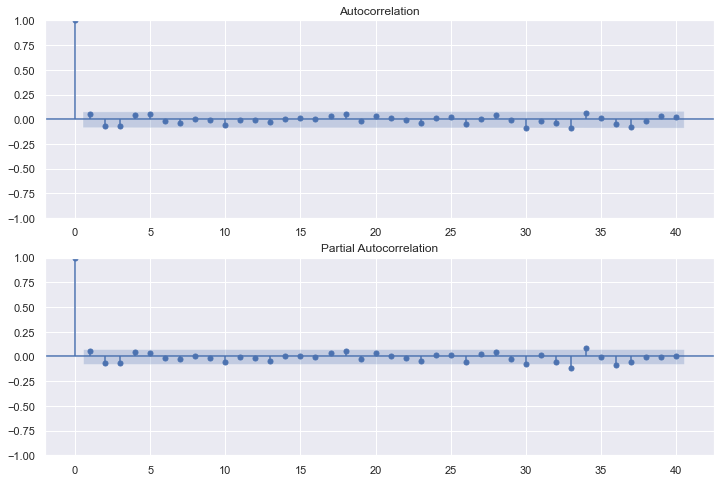

In [62]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trend_removed_train,lags = 40,ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trend_removed_train,lags = 40, ax = ax2)

In [63]:
def rmse(series1, series2):
    error = series1-series2
    se_error = error**2
    rmse_ = np.sqrt(np.mean(se_error))
    return rmse_

In [64]:
def mape(actual, predicted):
    error = actual-predicted
    abs_error = np.absolute(error)
    percent_abs_error = (abs_error/actual)*100
    mape_ = np.mean(percent_abs_error)
    return mape_

In [65]:
model = sm.tsa.statespace.SARIMAX(train['Close'],
                                  order = (7,1,0),
                                  seasonal_order = (0,0,0,0),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [66]:
results = model.fit()
print(results.summary())
print('\n\n')
print('RMSE {}'.format(rmse(results.fittedvalues, train['Close'])))
print('MAPE {}'.format(mape(train['Close'], results.fittedvalues)))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  600
Model:               SARIMAX(7, 1, 0)   Log Likelihood               -4572.304
Date:                Wed, 20 Sep 2023   AIC                           9160.607
Time:                        04:55:07   BIC                           9195.675
Sample:                             0   HQIC                          9174.267
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0550      0.033      1.644      0.100      -0.011       0.120
ar.L2         -0.0531      0.041     -1.309      0.191      -0.133       0.026
ar.L3         -0.0610      0.038     -1.597      0.1

Above is the set of parameters that works best after trying out the estimates of the parameters from PACF and ACF plot

In [67]:
predictions = results.forecast(steps = len(test))

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [68]:
predictions_df_arima = pd.Series(predictions.values,index = test.index,)

In [69]:
predictions_df_arima

Date
2023-06-07    62740.808269
2023-06-08    62722.833440
2023-06-09    62750.753299
2023-06-12    62769.029470
2023-06-13    62761.125871
2023-06-14    62749.363767
2023-06-15    62749.194672
2023-06-16    62753.716111
2023-06-19    62755.075488
2023-06-20    62753.148754
2023-06-21    62751.904688
2023-06-22    62752.413417
2023-06-23    62753.146661
2023-06-26    62753.140797
2023-06-27    62752.811133
2023-06-28    62752.718312
2023-06-30    62752.848158
2023-07-03    62752.931116
2023-07-04    62752.896535
2023-07-05    62752.847777
2023-07-06    62752.849016
2023-07-07    62752.871834
2023-07-10    62752.878018
2023-07-11    62752.869211
2023-07-12    62752.863673
2023-07-13    62752.866071
2023-07-14    62752.869354
2023-07-17    62752.869229
2023-07-18    62752.867672
2023-07-19    62752.867264
2023-07-20    62752.867864
2023-07-21    62752.868235
2023-07-24    62752.868068
2023-07-25    62752.867846
2023-07-26    62752.867857
2023-07-27    62752.867963
2023-07-28    62752.867

In [70]:
df_stock['Prediction'] = predictions_df_arima

In [71]:
df_stock

,Open,High,Low,Close,Adj Close,Volume,Prediction
Date,,,,,,,
2021-01-01,47785.281250,47984.359375,47771.148438,47868.980469,47868.980469,82700,NaN
2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,48176.800781,13900,NaN
2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,48437.781250,12200,NaN
2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,48174.058594,22500,NaN
2021-01-07,48524.359375,48558.339844,48037.871094,48093.320312,48093.320312,18400,NaN
...,...,...,...,...,...,...,...
2023-09-04,65525.910156,65683.906250,65285.558594,65628.140625,65628.140625,13700,62752.867944
2023-09-05,65671.601562,65831.703125,65601.468750,65780.257812,65780.257812,6600,62752.867944
2023-09-06,65744.187500,65971.132812,65488.031250,65880.523438,65880.523438,6100,62752.867944


<AxesSubplot:xlabel='Date'>

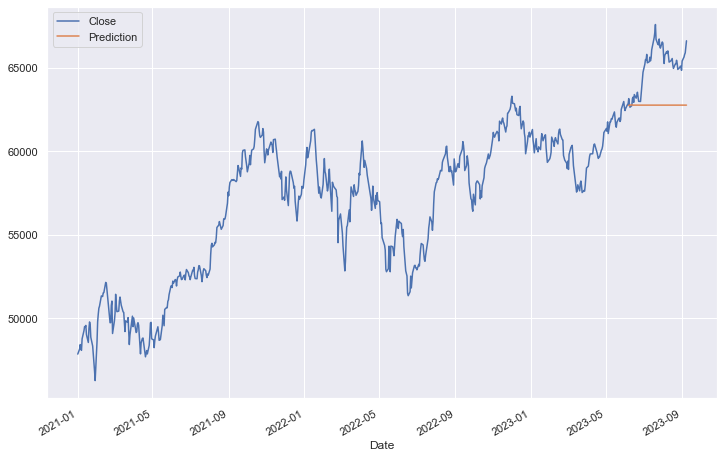

In [72]:
df_stock[['Close','Prediction']].plot(figsize = (12, 8))

# Error Calculation

In [73]:
rms = np.sqrt(mean_squared_error(test['Close'],predictions))
print("RMSE : ", rms)

RMSE :  2680.353538466909


# Stock prices are greatly dependent on their immediate lags, so we can't accurately forecast many days down the line with the help of ARIMA

Lets try to make use of the news headlines to predict stock prices

In [74]:
df_news = pd.read_csv('Dataset/india-news-headlines.csv',parse_dates=['publish_date'])

In [75]:
df_news

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; says Vajpayee
1,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
2,2001-01-02,unknown,America's unwanted heading for India?
3,2001-01-02,unknown,For bigwigs; it is destination Goa
4,2001-01-02,unknown,Extra buses to clear tourist traffic
...,...,...,...
3650965,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terror links
3650966,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his alcohol; food and ensured to have at least one meal together with family'
3650967,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern districts of Tamil Nadu; vaccination drive takes a hit
3650968,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases with 39 new patients


In [76]:
#Getting the news articles that are in our required date range
df_newsu = df_news[df_news['publish_date'] > dt.datetime(2020, 12, 30)]

In [77]:
list(filter(lambda x: 'sensex' in x, df_newsu['headline_text'].value_counts().index))

['Oil at nearly 14-year high; sensex sheds 1;500 points; rupee breaches 77/$',
 'After 5-day losing streak; sensex sees bounceback',
 'Sharp RIL rally helps sensex gain 454 pts',
 'RIL; Bharti help sensex regain 1k pts',
 'ril slides on aramco deal review triggers 1170 point sensex crash',
 'RIL; Kotak help sensex gain 153 pts',
 'Bull run: Another day of sensex; Nifty highs',
 'Rising crude gives markets jitters; pulls sensex down; rupee near 6-month low of Rs 75 per dollar',
 'E-surge for Tata stocks; sensex at new peak too',
 "US Fed's clarity on tapering takes sensex close to 60k",
 "Afraid of sensex's dizzying height? Take a deep breath",
 'Top 15 Gujarat companies shed Rs 92;000 crore as sensex dives',
 'sensex up 581 pts as it pharma rally on weak',
 'Auto; energy stocks drive sensex gains',
 'Rising US yields; crude prices spook St; sensex dips 656 pts',
 'Covid; yields sink sensex by 2k pts in just 5 sessions',
 'From crash of record 4k pts last year; sensex gains 95%; m-cap 2

# It seems like there are only fewer company related news in this article. But let's go ahead and see 

In [78]:
df_stock.drop(['Prediction','Adj Close'],axis = 1,inplace=True)

In [79]:
df_stock

,Open,High,Low,Close,Volume
Date,,,,,
2021-01-01,47785.281250,47984.359375,47771.148438,47868.980469,82700
2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,13900
2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,12200
2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,22500
2021-01-07,48524.359375,48558.339844,48037.871094,48093.320312,18400
...,...,...,...,...,...
2023-09-04,65525.910156,65683.906250,65285.558594,65628.140625,13700
2023-09-05,65671.601562,65831.703125,65601.468750,65780.257812,6600
2023-09-06,65744.187500,65971.132812,65488.031250,65880.523438,6100


In [80]:
df_newsu.drop('headline_category',axis=1,inplace=True)

In [81]:
stock_headlines = df_newsu.groupby(['publish_date'])['headline_text'].apply(lambda x: '.'.join(x)).reset_index()


In [82]:
stock_headlines.columns = ['Date','Headlines']

In [83]:
stock_headlines.set_index('Date', inplace= True)

In [84]:
stock_headlines

,Headlines
Date,
2020-12-31,Horoscope Today; 31 December 2020: Check astrological prediction for Aries; Taurus; Gemini; Cancer and other signs.How history made way for development in Vijayawada.2020 Recap: Bollywood's quarantine moments captured on camera! Watch their viral videos.Capricorn Horoscope 2021: Read yearly horo...
2021-01-01,Govt must consider I-T sops for spends on PCs.Horoscope Today; 01 January 2021: Check astrological prediction for Aries; Taurus; Gemini; Cancer and other signs.Monthly Horoscope January 2021: Check predictions for all zodiac signs.happy new year 2021 10 funny memes wishes messages and images abo...
2021-01-02,Horoscope Today; 02 January 2021: Check astrological prediction for Aries; Taurus; Gemini; Cancer and other signs.Super erotic tips to keep your woman happy in bed.Numerology Readings 02 January 2021: Predictions; Lucky Colour; Lucky Number & Remedies.Politics & Post-Pandemic Portents.Preparatio...
2021-01-03,Gemini Horoscope: How your love life and relationships will be in 2021.Horoscope Today; 03 January 2021: Check astrological prediction for Aries; Taurus; Gemini; Cancer and other signs.Numerology Readings 03 January 2021: Predictions; Lucky Colour; Lucky Number & Remedies.The virus put truth bac...
2021-01-04,Micro review: 'Ahalya's Awakening' by Kavita Kane.Horoscope Today; 04 January 2021: Check astrological prediction for Aries; Taurus; Gemini; Cancer and other signs.Cancer Horoscope: How your love life and relationships will be in 2021.Numerology Readings 04 January 2021: Predictions; Lucky Colou...
...,...
2022-03-27,Playing a dead man in Body God meant sitting in a refrigerator: Guruprasad.An intimate reception for Tejaswini Prakash.Karthik Mahesh returns to Kannada TV with new series.What it takes to deliver food on time.Is self-love good or bad? Spiritual song tries to find an answer to this.Atul Kulkarni...
2022-03-28,As fashion becomes democratic; demand for stylists soars.'The last 2 years taught me lessons that I have not learned in 20 years': Samyukta Hornad.We need to have more complicated and uncomfortable conversations: TM Krishna.Trikona's release pushed due to shortage of cinema halls.Lock Upp: Sara ...
2022-03-29,Bobby Deol: Like my dad; I hope to be working when I am his age.Yashas Surya shoots at historic sites in Badami.An engg grad with an eye on ISRO; Deepika Aradhya ends up debuting in Body God.Scratch the surface and watch the smiley fade.Designers' business gets boost at fashion week.Designers' b...


# Text Preprocessing

In [85]:
def text_preprocessing (text):
    text = re.sub('[^A-Za-z]+',' ', text) # remove all special symbol and numbers
    text = ' '.join([e.lower() for e in text.split() if e.lower() not in stop_words])
    text = ' '.join([WordNetLemmatizer().lemmatize(word) for word in text.split()])
    return text.strip()

In [86]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [87]:
stock_headlines['Headlines'] = stock_headlines['Headlines'].apply(text_preprocessing)

In [88]:
stock_headlines

,Headlines
Date,
2020-12-31,horoscope today december check astrological prediction aries taurus gemini cancer sign history made way development vijayawada recap bollywood quarantine moment captured camera watch viral video capricorn horoscope read yearly horoscope prediction love marriage career kid chinnu chandni play jud...
2021-01-01,govt must consider sop spends pc horoscope today january check astrological prediction aries taurus gemini cancer sign monthly horoscope january check prediction zodiac sign happy new year funny meme wish message image new year make laugh loud happy new year greeting card wish message image simp...
2021-01-02,horoscope today january check astrological prediction aries taurus gemini cancer sign super erotic tip keep woman happy bed numerology reading january prediction lucky colour lucky number remedy politics post pandemic portent preparation full swing rollout covid vaccine studio kochi urban future...
2021-01-03,gemini horoscope love life relationship horoscope today january check astrological prediction aries taurus gemini cancer sign numerology reading january prediction lucky colour lucky number remedy virus put truth back business strive best version bellamkonda sai sreenivas sustainable marine plan...
2021-01-04,micro review ahalya awakening kavita kane horoscope today january check astrological prediction aries taurus gemini cancer sign cancer horoscope love life relationship numerology reading january prediction lucky colour lucky number remedy mysuru bahuroopi national theatre festival pushed april n...
...,...
2022-03-27,playing dead man body god meant sitting refrigerator guruprasad intimate reception tejaswini prakash karthik mahesh return kannada tv new series take deliver food time self love good bad spiritual song try find answer atul kulkarni ott v cinema narrative redundant coexistence today nargis fakhri...
2022-03-28,fashion becomes democratic demand stylist soar last year taught lesson learned year samyukta hornad need complicated uncomfortable conversation tm krishna trikona release pushed due shortage cinema hall lock upp sara khan latest contestant get evicted show lock upp sara khan latest contestant ge...
2022-03-29,bobby deol like dad hope working age yashas surya shoot historic site badami engg grad eye isro deepika aradhya end debuting body god scratch surface watch smiley fade designer business get boost fashion week designer business get boost fashion week mika singh said rishtas last year mika singh s...


# Calculating Sentiment Scores

In [89]:
sent_analyzer = SentimentIntensityAnalyzer()

In [90]:
# calculating sentiment scores
stock_headlines['Compound'] = stock_headlines['Headlines'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
stock_headlines['Negative'] = stock_headlines['Headlines'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
stock_headlines['Neutral'] = stock_headlines['Headlines'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
stock_headlines['Positive'] = stock_headlines['Headlines'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])

In [91]:
stock_headlines

,Headlines,Compound,Negative,Neutral,Positive
Date,,,,,
2020-12-31,horoscope today december check astrological prediction aries taurus gemini cancer sign history made way development vijayawada recap bollywood quarantine moment captured camera watch viral video capricorn horoscope read yearly horoscope prediction love marriage career kid chinnu chandni play jud...,-0.9995,0.149,0.741,0.111
2021-01-01,govt must consider sop spends pc horoscope today january check astrological prediction aries taurus gemini cancer sign monthly horoscope january check prediction zodiac sign happy new year funny meme wish message image new year make laugh loud happy new year greeting card wish message image simp...,-0.9989,0.148,0.729,0.123
2021-01-02,horoscope today january check astrological prediction aries taurus gemini cancer sign super erotic tip keep woman happy bed numerology reading january prediction lucky colour lucky number remedy politics post pandemic portent preparation full swing rollout covid vaccine studio kochi urban future...,-0.9960,0.132,0.746,0.122
2021-01-03,gemini horoscope love life relationship horoscope today january check astrological prediction aries taurus gemini cancer sign numerology reading january prediction lucky colour lucky number remedy virus put truth back business strive best version bellamkonda sai sreenivas sustainable marine plan...,-0.9997,0.166,0.718,0.116
2021-01-04,micro review ahalya awakening kavita kane horoscope today january check astrological prediction aries taurus gemini cancer sign cancer horoscope love life relationship numerology reading january prediction lucky colour lucky number remedy mysuru bahuroopi national theatre festival pushed april n...,-0.9999,0.171,0.728,0.100
...,...,...,...,...,...
2022-03-27,playing dead man body god meant sitting refrigerator guruprasad intimate reception tejaswini prakash karthik mahesh return kannada tv new series take deliver food time self love good bad spiritual song try find answer atul kulkarni ott v cinema narrative redundant coexistence today nargis fakhri...,-0.9999,0.169,0.738,0.092
2022-03-28,fashion becomes democratic demand stylist soar last year taught lesson learned year samyukta hornad need complicated uncomfortable conversation tm krishna trikona release pushed due shortage cinema hall lock upp sara khan latest contestant get evicted show lock upp sara khan latest contestant ge...,-0.9998,0.167,0.727,0.106
2022-03-29,bobby deol like dad hope working age yashas surya shoot historic site badami engg grad eye isro deepika aradhya end debuting body god scratch surface watch smiley fade designer business get boost fashion week designer business get boost fashion week mika singh said rishtas last year mika singh s...,-0.9997,0.153,0.755,0.092


In [92]:
df_stock_news = pd.concat([df_stock,stock_headlines],axis=1)
df_stock_news.dropna(inplace=True)

In [93]:
df_stock_news

,Open,High,Low,Close,Volume,Headlines,Compound,Negative,Neutral,Positive
Date,,,,,,,,,,
2021-01-01,47785.281250,47984.359375,47771.148438,47868.980469,82700.0,govt must consider sop spends pc horoscope today january check astrological prediction aries taurus gemini cancer sign monthly horoscope january check prediction zodiac sign happy new year funny meme wish message image new year make laugh loud happy new year greeting card wish message image simp...,-0.9989,0.148,0.729,0.123
2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,13900.0,micro review ahalya awakening kavita kane horoscope today january check astrological prediction aries taurus gemini cancer sign cancer horoscope love life relationship numerology reading january prediction lucky colour lucky number remedy mysuru bahuroopi national theatre festival pushed april n...,-0.9999,0.171,0.728,0.100
2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,12200.0,numerology reading january prediction lucky colour lucky number remedy nashik woman held killing year old son cave traffic movement restored basna bridge six site selected prayagraj covid vaccination dry run abap seer oppose granting recognition new akhara year long prog mark yr chauri chaura in...,-0.9997,0.155,0.738,0.107
2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,22500.0,go pro tem chairmanin legislative council till oct next get husband mood sex numerology reading january prediction lucky colour lucky number remedy kirti kulhari everyone projecting idea ideal life social medium farmer happy rain cold say help pulse wheat mustard cucumber health benefit reason e...,-0.9998,0.167,0.735,0.099
2021-01-07,48524.359375,48558.339844,48037.871094,48093.320312,18400.0,chasing winter sun abu dhabi know scheduling sex might good relationship trace virus found air hosps study miracle son survived take child bike nmc seek objection tax payer real estate sector pick nashik season first container grape exported nashik germany nylon manja bombay hc adjourns hearing ...,-0.9999,0.169,0.746,0.085
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,57801.718750,57845.371094,57100.238281,57362.199219,6900.0,speeding shortcut tackling unruly customer take deliver food time accept role satisfy creativity suresh heblikar manoj kumar give romance break take thriller body god rakul preet singh gave time meditation reading learnt patience lockdown political vendetta became maharashtra favourite sport sho...,-0.9999,0.186,0.732,0.082
2022-03-28,57472.718750,57638.339844,56825.089844,57593.488281,6300.0,fashion becomes democratic demand stylist soar last year taught lesson learned year samyukta hornad need complicated uncomfortable conversation tm krishna trikona release pushed due shortage cinema hall lock upp sara khan latest contestant get evicted show lock upp sara khan latest contestant ge...,-0.9998,0.167,0.727,0.106
2022-03-29,57814.761719,58001.531250,57639.351562,57943.648438,12100.0,bobby deol like dad hope working age yashas surya shoot historic site badami engg grad eye isro deepika aradhya end debuting body god scratch surface watch smiley fade designer business get boost fashion week designer business get boost fashion week mika singh said rishtas last year mika singh s...,-0.9997,0.153,0.755,0.092


In [94]:
df_stock_news.drop('Headlines',axis=1,inplace=True)

In [95]:
df_stock_news['Close'].shift(1)

Date
2021-01-01             NaN
2021-01-04    47868.980469
2021-01-05    48176.800781
2021-01-06    48437.781250
2021-01-07    48174.058594
                  ...     
2022-03-25    57595.679688
2022-03-28    57362.199219
2022-03-29    57593.488281
2022-03-30    57943.648438
2022-03-31    58683.988281
Name: Close, Length: 308, dtype: float64

In [96]:
# shifting next day close
df_stock_news['Close_predictor'] = df_stock_news['Close'].shift(1) 

# shifting next day compound
df_stock_news['compound_shifted'] = df_stock_news['Compound'].shift(1) 

df_stock_news = df_stock_news.dropna()    



In [97]:
df_stock_news.head(10)


,Open,High,Low,Close,Volume,Compound,Negative,Neutral,Positive,Close_predictor,compound_shifted
Date,,,,,,,,,,,
2021-01-04,48109.171875,48220.468750,47594.468750,48176.800781,13900.0,-0.9999,0.171,0.728,0.100,47868.980469,-0.9989
2021-01-05,48037.628906,48486.238281,47903.378906,48437.781250,12200.0,-0.9997,0.155,0.738,0.107,48176.800781,-0.9999
2021-01-06,48616.660156,48616.660156,47864.140625,48174.058594,22500.0,-0.9998,0.167,0.735,0.099,48437.781250,-0.9997
2021-01-07,48524.359375,48558.339844,48037.871094,48093.320312,18400.0,-0.9999,0.169,0.746,0.085,48174.058594,-0.9998
2021-01-08,48464.910156,48854.339844,48365.578125,48782.511719,22200.0,-0.9999,0.202,0.722,0.076,48093.320312,-0.9999
2021-01-11,49252.308594,49303.789062,48956.378906,49269.320312,21200.0,-0.9999,0.193,0.710,0.097,48782.511719,-0.9999
2021-01-12,49228.261719,49569.140625,49079.570312,49517.109375,12700.0,-0.9999,0.184,0.730,0.086,49269.320312,-0.9999
2021-01-13,49763.929688,49795.191406,49073.851562,49492.320312,27200.0,-0.9998,0.156,0.755,0.088,49517.109375,-0.9999
2021-01-14,49432.828125,49663.578125,49182.371094,49584.160156,24500.0,-0.9999,0.168,0.741,0.090,49492.320312,-0.9998


In [98]:
x = df_stock_news.drop(['Close','Negative','Positive','Neutral','Compound'],axis=1)
y = df_stock_news['Close']


# Model Building

In [99]:
x

,Open,High,Low,Volume,Close_predictor,compound_shifted
Date,,,,,,
2021-01-04,48109.171875,48220.468750,47594.468750,13900.0,47868.980469,-0.9989
2021-01-05,48037.628906,48486.238281,47903.378906,12200.0,48176.800781,-0.9999
2021-01-06,48616.660156,48616.660156,47864.140625,22500.0,48437.781250,-0.9997
2021-01-07,48524.359375,48558.339844,48037.871094,18400.0,48174.058594,-0.9998
2021-01-08,48464.910156,48854.339844,48365.578125,22200.0,48093.320312,-0.9999
...,...,...,...,...,...,...
2022-03-25,57801.718750,57845.371094,57100.238281,6900.0,57595.679688,-0.9999
2022-03-28,57472.718750,57638.339844,56825.089844,6300.0,57362.199219,-0.9999
2022-03-29,57814.761719,58001.531250,57639.351562,12100.0,57593.488281,-0.9998


In [100]:
0.70*len(x)

214.89999999999998

In [101]:
x_train = x[:210]
x_test = x[210:]
y_train = y[:210]
y_test = y[210:]

# RandomForestRegressor Model

In [102]:
rf_1 = RandomForestRegressor()
rf_1.fit(x_train, y_train)


RandomForestRegressor()

In [103]:
print_score(rf_1)


Training R2 Score: 
0.9992465404515777

Testing R2 Score: 
0.9363497379208322

Training RMSE: 
113.00388116206193

Test RMSE: 
424.7081195052322


# DecisionTreeRegressor Model

In [104]:

dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)


DecisionTreeRegressor()

In [105]:
print_score(dtr)


Training R2 Score: 
1.0

Testing R2 Score: 
0.8637262266957054

Training RMSE: 
0.0

Test RMSE: 
621.4362832296429


# AdaBoostRegressor Model

In [106]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [107]:
print_score(adb)


Training R2 Score: 
0.9972227232219241

Testing R2 Score: 
0.9330179390138726

Training RMSE: 
216.956652171545

Test RMSE: 
435.6821015977531


# Linear Regression Model

In [108]:
lr_1 = LinearRegression()
lr_1.fit(x_train, y_train)

LinearRegression()

In [109]:
print_score(lr_1)


Training R2 Score: 
0.9986380342556451

Testing R2 Score: 
0.9833820136965333

Training RMSE: 
151.93102979680418

Test RMSE: 
217.0099585931986


# XGBRegressor Model

In [110]:
xgb = XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [111]:
print_score(xgb)


Training R2 Score: 
0.9999995916976002

Testing R2 Score: 
0.923070721706666

Training RMSE: 
2.630597212198133

Test RMSE: 
466.9133536082133


# Prediction Plot on unseen data using LR

In [112]:
prediction_final = lr_1.predict(x_test)

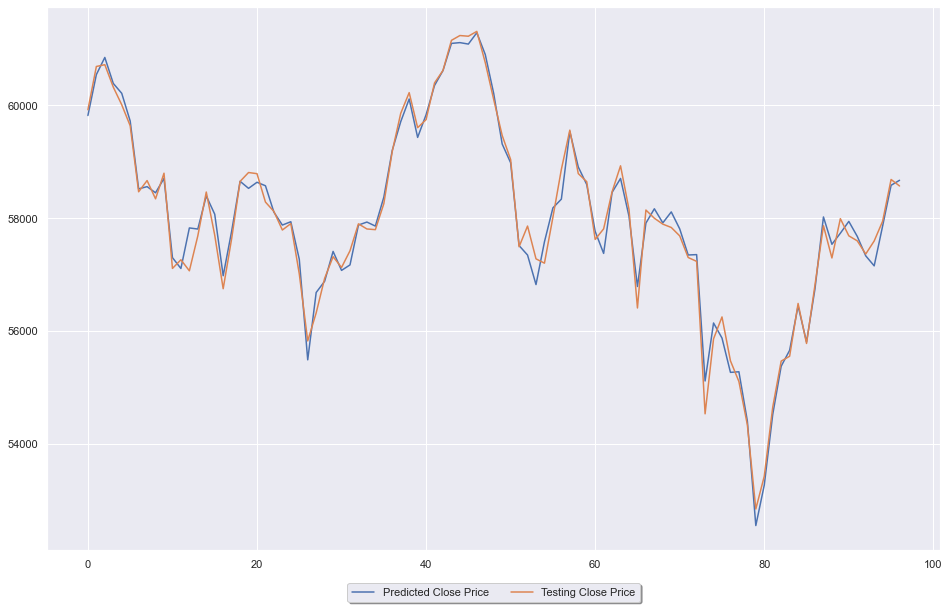

In [113]:
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(prediction_final, label="Predicted Close Price")
plt.plot([row for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

# Conclusion

- From the above results, the linear regression still outperformes all other tree based and ensemble methods. As we have seen in the top the stock price has a strong relationship to its immediate lag stock price and thus it is able to capture/ predict the price accurately with its historical data

- Adding the sentiment analysis of the news headlines even though it wasn't that relevant seemed to improve the 
accuracy in the Random Forest Regressor when we compared it to the above model where we trained it without the news
headlines data. But it is important to note that we used different ranges (sizes) of training and test data in both the case